In [0]:
%%capture
!pip install --quiet --upgrade pip
!pip install --quiet cirq==0.7

# Rabi Oscillation Experiment

In this experiment, you are going to use Cirq to check that rotating a qubit by an increasing angle, and then measuring the qubit, produces Rabi oscillations. This requires you to do the following things:

1. Prepare the $|0\rangle$ state.
2. Rotate by an angle $\theta$ around the $X$ axis.
3. Measure to see if the result is a 1 or a 0.
4. Repeat steps 1-3 $k$ times.
5. Report the fraction of $\frac{\text{Number of 1's}}{k}$
found in step 3.

## 1. Getting to know Cirq

Cirq emphasizes the details of implementing quantum algorithms on near term devices.
For example, when you work on a qubit in Cirq you don't operate on an unspecified qubit that will later be mapped onto a device by a hidden step.
Instead, you are always operating on specific qubits at specific locations that you specify.

Suppose you are working with a 54 qubit Sycamore chip.
This device is included in Cirq by default.
It is called `cirq.google.Sycamore`, and you can see its layout by printing it.

In [2]:
import cirq
working_device = cirq.google.Sycamore
print(working_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

For this experiment you only need one qubit and you can just pick whichever one you like.

In [0]:
my_qubit = cirq.GridQubit(5, 6)

Once you've chosen your qubit you can build circuits that use it.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


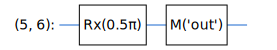

In [4]:
from cirq.contrib.svg import SVGCircuit

# Create a circuit with X, Ry(pi/2) and H.
my_circuit = cirq.Circuit(
    # Rotate the qubit pi/2 radians around the X axis.
    cirq.rx(3.141 / 2).on(my_qubit),
    # Measure the qubit.
    cirq.measure(my_qubit, key='out')
)
SVGCircuit(my_circuit)

Now you can simulate sampling from your circuit using `cirq.Simulator`.

In [5]:
sim = cirq.Simulator()
samples = sim.sample(my_circuit, repetitions=10)
samples

,out
0,1
1,0
2,0
3,1
4,1
5,0
6,1
7,1
8,0
9,1


You can also get properties of the circuit, such as the density matrix of the circuit's output or the wavefunction just before the terminal measurement.

In [6]:
wavefuntion_before_measurement = sim.simulate(my_circuit[:-1])
sampled_wavefunction_after_measurement = sim.simulate(my_circuit)

print(f'State before measurement:')
print(wavefuntion_before_measurement)
print(f'State after measurement:')
print(sampled_wavefunction_after_measurement)


State before measurement:
measurements: (no measurements)
output vector: 0.707|0⟩ - 0.707j|1⟩
State after measurement:
measurements: out=1
output vector: -1j|1⟩


You can also examine the outputs from a noisy environment.
For example, an environment where 10% depolarization is applied to each qubit after each operation in the circuit:

In [7]:
noisy_sim = cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.1))
noisy_post_measurement_state = noisy_sim.simulate(my_circuit)
noisy_pre_measurement_state = noisy_sim.simulate(my_circuit[:-1])

print('Noisy state after measurement:' + str(noisy_post_measurement_state))
print('Noisy state before measurement:' + str(noisy_pre_measurement_state))

Noisy state after measurement:measurements: out=0
final density matrix:
[[0.9333334 +0.j 0.        +0.j]
 [0.        +0.j 0.06666666+0.j]]
Noisy state before measurement:measurements: (no measurements)
final density matrix:
[[0.50012845+0.j         0.        +0.43333334j]
 [0.        -0.43333334j 0.49987155+0.j        ]]


## 2. Parameterized Circuits and Sweeps

Now that you have some of the basics end to end, you can create a parameterized circuit that rotates by an angle $\theta$:

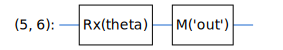

In [8]:
import sympy
theta = sympy.Symbol('theta')

parameterized_circuit = cirq.Circuit(
    cirq.rx(theta).on(my_qubit),
    cirq.measure(my_qubit, key='out')
)
SVGCircuit(parameterized_circuit)

In the above block you saw that there is a `sympy.Symbol` that you placed in the circuit. Cirq supports symbolic computation involving circuits. What this means is that when you construct `cirq.Circuit` objects you can put placeholders in many of the classical control parameters of the circuit which you can fill with values later on.

Now if you wanted to use `cirq.simulate` or `cirq.sample` with the parameterized circuit you would also need to specify a value for `theta`.

In [9]:
samples_at_theta_equals_2 = sim.sample(
    parameterized_circuit, 
    params={theta: 2}, 
    repetitions=10)
samples_at_theta_equals_2

,theta,out
0,2,1
1,2,0
2,2,1
3,2,1
4,2,1
5,2,0
6,2,1
7,2,0
8,2,1
9,2,0


You can also specify *multiple* values of `theta`, and get samples back for each value.

In [10]:
samples_at_multiple_theta = sim.sample(
    parameterized_circuit, 
    params=[{theta: 0.5}, {theta: 3.141}], 
    repetitions=10)
samples_at_multiple_theta

,theta,out
0,0.500,0
1,0.500,0
2,0.500,0
3,0.500,0
4,0.500,0
5,0.500,0
6,0.500,0
7,0.500,0
8,0.500,0
9,0.500,0


Cirq has shorthand notation you can use to sweep `theta` over a range of values.

In [11]:
samples_at_swept_theta = sim.sample(
    parameterized_circuit, 
    params=cirq.Linspace(theta, start=0, stop=3.14159, length=5), 
    repetitions=5)
samples_at_swept_theta

,theta,out
0,0.000000,0
1,0.000000,0
2,0.000000,0
3,0.000000,0
4,0.000000,0
0,0.785397,0
1,0.785397,0
2,0.785397,0
3,0.785397,0
4,0.785397,0


The result value being returned by `sim.sample` is a `pandas.DataFrame` object.
Pandas is a common library for working with table data in python.
You can use standard pandas methods to analyze and summarize your results.

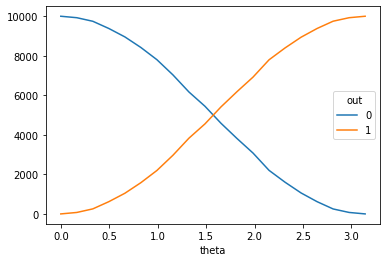

In [12]:
import pandas

big_results = sim.sample(
    parameterized_circuit, 
    params=cirq.Linspace(theta, start=0, stop=3.14159, length=20), 
    repetitions=10_000)

# big_results is too big to look at. Plot cross tabulated data instead.
pandas.crosstab(big_results.theta, big_results.out).plot()

## 3. The built-in experiment

Cirq comes with a pre-written Rabi oscillation experiment `cirq.experiments.rabi_oscillations`.
This method takes a `cirq.Sampler`, which could be a simulator or a network connection to real hardware.
The method takes a few more experimental parameters, and returns a result object
that can be plotted.

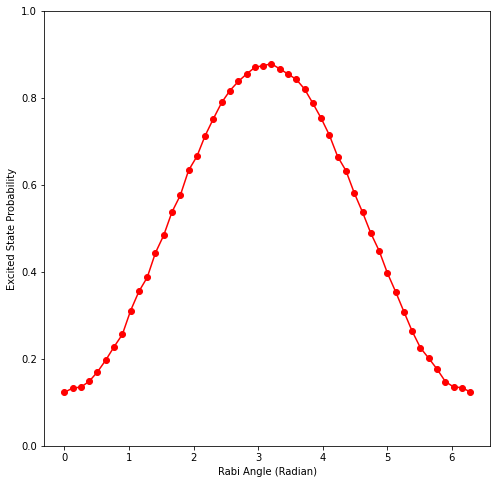

In [13]:
import datetime

result = cirq.experiments.rabi_oscillations(
    sampler=noisy_sim,
    qubit=my_qubit,
    num_points=50,
    repetitions=10000)
result.plot()

Notice that you can tell from the plot that you used the noisy simulator you defined earlier.
You can also tell that the amount of depolarization is roughly 10%.

## 4. Exercise: Find the best qubit

As you have seen, you can use Cirq to perform a Rabi oscillation experiment.
You can either make the experiment yourself out of the basic pieces made available by Cirq, or use the prebuilt experiment method.

Now you're going to put this knowledge to the test.

There is some amount of depolarizing noise on each qubit.
Your goal is to characterize every qubit from the Sycamore chip using a Rabi oscillation experiment, and find the qubit with the lowest noise according to the secret noise model.

In [0]:
import hashlib

class SecretNoiseModel(cirq.NoiseModel):
    def noisy_operation(self, op):
        # Hey! No peeking!
        q = op.qubits[0]
        v = hashlib.sha256(str(q).encode()).digest()[0] / 256
        yield cirq.depolarize(v).on(q)
        yield op

secret_noise_sampler = cirq.DensityMatrixSimulator(noise=SecretNoiseModel())

qubit cirq.GridQubit(1, 5)


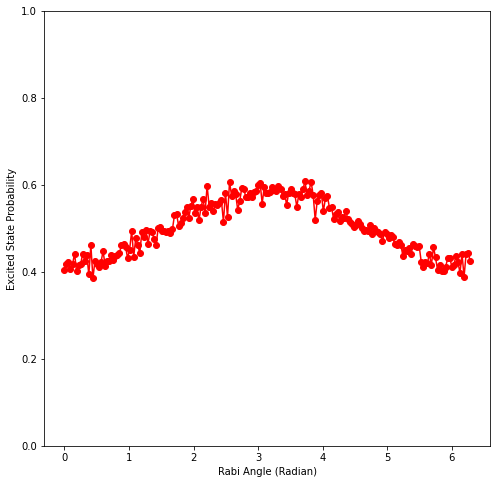

In [15]:
q = cirq.google.Sycamore.qubits[3]
print('qubit', repr(q))
cirq.experiments.rabi_oscillations(
    sampler=secret_noise_sampler,
    qubit=q
).plot()